# ClientCo use case : Churn Detection

Plan du notebook :
1. Imports
2. Data loading
3. Churn Detection<br />
    3.1 Feature engineering<br />
    3.2 Classification models<br />
    3.3 Grid search<br />
    3.4 Business case quantification<br />
    3.5 Explainability<br />
4. Basic example of client segmentation

## 1. Imports

In [2]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from tqdm import tqdm
from time import time
from numpy.random import choice
from random import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import shap

In [84]:
sns.set(rc={'figure.figsize':(15,8)})

## 2. Data Loading

In [16]:
df1 = pd.read_csv('dataset_sales_2.csv', sep = ';')

In [4]:
df1.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051


In [17]:
#Converting date from string to datetime (can take a few minutes)
df1['date_order'] = df1['date_order'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

In [18]:
#Creating a copy where we filtered out negative orders
df2 = df1[df1['sales_net'] > 0].copy()

## 3. Churn prediction

### 3.1 Preprocessing

In [21]:
# rfm returns recency, frequency and monetary features 
def rfm(df_orders, date, client_id):
    df_client = df_orders[df_orders.client_id == client_id]
    df_client_1 = df_client[df_client.date_order > (date - timedelta(30))]
    last_order = df_client.date_order.max()
    first_order = df_client.date_order.min()
    delta = (date - first_order).days
    r = (date-last_order).days
    f6 = df_client.date_order.nunique() / (delta + 1)
    m6 = df_client.sales_net.sum()
    delta_1 = max(delta, 29)
    f1 = df_client_1.date_order.nunique() / (delta_1 + 1)
    m1 = df_client_1.sales_net.sum()
    f_ratio = 0
    if f6 != 0:
        f_ratio = f1/f6
    m_ratio = 0
    if m6 != 0:
        m_ratio = 6*m1/m6
    return (r,f6,f1, m6, m1, f_ratio, m_ratio)


#channels returns whether the client used the different canals are not
def channels(df_orders, client) :
    df_client = df_orders[df_orders.client_id == client]
    channels = df_client.order_channel.unique()
    (online, store, phone, visit, other) = (0, 0, 0, 0, 0)
    if 'online' in channels :
        online = 1
    if 'at the store' in channels :
        store = 1
    if 'by phone' in channels :
        phone = 1
    if 'during the visit of a sales rep' in channels :
        visit = 1
    if 'other' in channels :
        other = 1
    return (online, store, phone, visit, other)

#is_churn returns the target. We consider a customer to be churn if his sales dropped 10 times or more after a certain date
def is_churn(df_before, df_after, client_id, time_ratio):
    client_before = df_before[df_before.client_id == client_id]
    client_after = df_after[df_after.client_id == client_id]
    if len(client_before) > 10*time_ratio*len(client_after) :
        return 1
    return 0

In [636]:
#Les dates sont choisies arbitrairement pour constituer le training set
dates = [datetime(2018, 6,1), datetime(2018, 8,6), datetime(2018, 10,11), datetime(2018, 12,16), datetime(2019, 2,21), datetime(2019, 4,26)]

#Nombre de clients choisis aléatoirement pour chaque date
n_per_date = 20000 

In [637]:
#Computing the training dataset (took ~40 minutes to compute 120k lines)
df_train = pd.DataFrame()
for date in dates :
    t0 = time()
    print("Date :", date)
    print("Computing dataframes")
    df_before_1 = df2[df2.date_order < date]
    df_before_1 = df_before_1[df_before_1.date_order >= (date - timedelta(30))]

    df_before_6 = df2[df2.date_order < date]
    df_before_6 = df_before_6[df_before_6.date_order >= (date - timedelta(180))]

    df_after = df2[df2.date_order >= date]
    df_after = df_after[df_after.date_order < (date + timedelta(90))]
    
    df_train_date = df_before_6.copy()
    clients_to_keep = choice(a = df_train_date.client_id.unique(), size = min(n_per_date, df_train_date.client_id.nunique()), replace=False)
    df_train_date = df_train_date[df_train_date.client_id.isin(clients_to_keep)]
    df_train_date = df_train_date.groupby(['client_id']).agg({'date_invoice' : 'count', 'product_id' : 'nunique', 'branch_id' : 'nunique'}).reset_index()
    df_train_date.rename(columns = {'date_invoice' : 'nb_orders',
                               'product_id' : 'nb_products',
                               'branch_id' : 'nb_branches'}, inplace = True)
    
    print("Computing features")

    df_train_date['R'] = 0
    df_train_date['F6'] = 0
    df_train_date['F1'] = 0
    df_train_date['M6'] = 0
    df_train_date['M1'] = 0
    df_train_date['F_ratio'] = 0
    df_train_date['M_ratio'] = 0

    for client in tqdm(df_train_date.client_id.unique()):
        (r,f6,f1, m6, m1, f_r, m_r) = rfm(df_before_6, date, client)
        df_train_date.loc[df_train_date.client_id == client, 'R'] = r
        df_train_date.loc[df_train_date.client_id == client, 'F6'] = f6
        df_train_date.loc[df_train_date.client_id == client, 'F1'] = f1
        df_train_date.loc[df_train_date.client_id == client, 'M6'] = m6
        df_train_date.loc[df_train_date.client_id == client, 'M1'] = m1
        df_train_date.loc[df_train_date.client_id == client, 'F_ratio'] = f_r
        df_train_date.loc[df_train_date.client_id == client, 'M_ratio'] = m_r
        
    df_train_date['mean_basket'] = df_train_date['M6']/df_train_date['nb_orders']

    df_train_date['Online'] = 0
    df_train_date['Store'] = 0
    df_train_date['Phone'] = 0
    df_train_date['Visit'] = 0
    df_train_date['Other'] = 0


    for client in tqdm(df_train_date.client_id.unique()):
        (online, store, phone, visit, other) = channels(df_before_6, client)
        df_train_date.loc[df_train_date.client_id == client, 'Online'] = online
        df_train_date.loc[df_train_date.client_id == client, 'Store'] = store
        df_train_date.loc[df_train_date.client_id == client, 'Phone'] = phone
        df_train_date.loc[df_train_date.client_id == client, 'Visit'] = visit
        df_train_date.loc[df_train_date.client_id == client, 'Other'] = other
        
    print("Computing Target")
        
    df_train_date['churn'] = 0
    for client in tqdm(df_train_date.client_id.unique()):
        df_train_date.loc[df_train_date.client_id == client, 'churn'] = is_churn(df_before_6, df_after, client, 2)
    
    df_train = df_train.append(df_train_date)
    print('Running time :', round(time()-t0, 2))
    print("##############")
    


Date : 2018-06-01 00:00:00
Computing dataframes


  0%|          | 7/20000 [00:00<05:08, 64.76it/s]

Computing features


  0%|          | 7/20000 [00:00<05:08, 64.89it/s]

Computing Target


100%|██████████| 20000/20000 [05:14<00:00, 63.55it/s]


Running time : 868.97
##############
Date : 2018-08-06 00:00:00
Computing dataframes


  0%|          | 7/20000 [00:00<04:53, 68.01it/s]

Computing features


  0%|          | 7/20000 [00:00<05:06, 65.29it/s]

Computing Target


100%|██████████| 20000/20000 [05:14<00:00, 63.54it/s]


Running time : 877.52
##############
Date : 2018-10-11 00:00:00
Computing dataframes


  0%|          | 7/20000 [00:00<05:14, 63.49it/s]

Computing features


  0%|          | 7/20000 [00:00<05:01, 66.25it/s]

Computing Target


100%|██████████| 20000/20000 [05:05<00:00, 65.52it/s]


Running time : 865.48
##############
Date : 2018-12-16 00:00:00
Computing dataframes


  0%|          | 7/20000 [00:00<05:06, 65.13it/s]

Computing features


  0%|          | 7/20000 [00:00<05:17, 63.00it/s]

Computing Target


100%|██████████| 20000/20000 [05:18<00:00, 62.72it/s]


Running time : 907.97
##############
Date : 2019-02-21 00:00:00
Computing dataframes


  0%|          | 14/20000 [00:00<04:52, 68.35it/s]

Computing features


  0%|          | 7/20000 [00:00<04:59, 66.82it/s]

Computing Target


100%|██████████| 20000/20000 [05:00<00:00, 66.55it/s]


Running time : 859.85
##############
Date : 2019-04-26 00:00:00
Computing dataframes


  0%|          | 7/20000 [00:00<05:04, 65.57it/s]

Computing features


  0%|          | 7/20000 [00:00<05:13, 63.78it/s]

Computing Target


100%|██████████| 20000/20000 [05:15<00:00, 63.47it/s]


Running time : 892.45
##############


In [638]:
len(df_train)

120000

In [639]:
df_train.head()

,client_id,nb_orders,nb_products,nb_branches,R,F6,F1,M6,M1,F_ratio,M_ratio,mean_basket,Online,Store,Phone,Visit,Other,churn
0,18,550,313,1,1,0.393258,0.033708,55247.500375,3498.600495,0.085714,0.379956,100.450001,0,1,1,0,0,0
1,118,81,64,6,2,0.121951,0.030488,13729.912376,7321.364002,0.250000,3.199451,169.505091,0,1,1,0,0,0
2,227,30,19,2,1,0.086093,0.006623,9028.300783,650.283600,0.076923,0.432163,300.943359,0,1,1,0,0,0
3,280,19,16,2,64,0.055944,0.000000,3451.793149,0.000000,0.000000,0.000000,181.673324,0,0,1,0,0,0
4,334,16,12,2,71,0.033898,0.000000,4414.863305,0.000000,0.000000,0.000000,275.928957,0,1,1,0,0,0


In [640]:
df_train.churn.value_counts()

0    85870
1    34130
Name: churn, dtype: int64

In [641]:
df_train.to_csv('dataset_train.csv')

## 3.2 Classification models

In [3]:
df_train = pd.read_csv('dataset_train.csv').drop(columns = ['Unnamed: 0'], axis = 1)
df_train = df_train.drop_duplicates(subset = 'client_id', keep = 'last').copy()

In [4]:
df_train_small = df_train.head(10000).copy()

In [113]:
X = df_train.drop(columns = ['churn', 'client_id'], axis = 1)
y = df_train['churn']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

La mesure qui nous intéresse le plus est le rappel car classifier un client comme churn alors qu'il ne l'est pas vraiment est moins dommageable que de classifier un client comme non-churn alors qu'il l'est. </br>
Toutefois on vérifie tout de même les autres mesures pour s'assurer que le modèle reste cohérent. 

In [89]:
clf = RandomForestClassifier(n_jobs = -1, random_state = 1)

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), n_jobs = -1)

print('----- Random Forest -----')
print('Accuracy : {} %'.format(np.round(100*cv_results['test_accuracy'].mean(),2)))
print('Precision : {} %'.format(np.round(100*cv_results['test_precision'].mean(),2)))
print('Rappel : {} %'.format(np.round(100*cv_results['test_recall'].mean(),2)))
print('F1 Score : {} %'.format(np.round(100*cv_results['test_f1'].mean(),2)))
print('ROC AUC : {} %'.format(np.round(100*cv_results['test_roc_auc'].mean(),2)))

----- Random Forest -----
Accuracy : 76.47 %
Precision : 65.53 %
Rappel : 58.74 %
F1 Score : 61.95 %
ROC AUC : 83.29 %


In [90]:
clf = SVC(random_state = 1)

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), n_jobs = -1)

print('----- SVC -----')
print('Accuracy : {} %'.format(np.round(100*cv_results['test_accuracy'].mean(),2)))
print('Precision : {} %'.format(np.round(100*cv_results['test_precision'].mean(),2)))
print('Rappel : {} %'.format(np.round(100*cv_results['test_recall'].mean(),2)))
print('F1 Score : {} %'.format(np.round(100*cv_results['test_f1'].mean(),2)))
print('ROC AUC : {} %'.format(np.round(100*cv_results['test_roc_auc'].mean(),2)))

----- SVC -----
Accuracy : 76.94 %
Precision : 64.33 %
Rappel : 65.68 %
F1 Score : 64.99 %
ROC AUC : 82.1 %


In [91]:
clf = KNeighborsClassifier(n_neighbors = 5)

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), n_jobs = -1)

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(100*cv_results['test_accuracy'].mean(),2)))
print('Precision : {} %'.format(np.round(100*cv_results['test_precision'].mean(),2)))
print('Rappel : {} %'.format(np.round(100*cv_results['test_recall'].mean(),2)))
print('F1 Score : {} %'.format(np.round(100*cv_results['test_f1'].mean(),2)))
print('ROC AUC : {} %'.format(np.round(100*cv_results['test_roc_auc'].mean(),2)))

----- KNN -----
Accuracy : 74.85 %
Precision : 62.04 %
Rappel : 58.89 %
F1 Score : 60.42 %
ROC AUC : 79.34 %


In [92]:
clf = MLPClassifier(tol = 0.0001, max_iter = 500)

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), n_jobs = -1)

print('----- MLP -----')
print('Accuracy : {} %'.format(np.round(100*cv_results['test_accuracy'].mean(),2)))
print('Precision : {} %'.format(np.round(100*cv_results['test_precision'].mean(),2)))
print('Rappel : {} %'.format(np.round(100*cv_results['test_recall'].mean(),2)))
print('F1 Score : {} %'.format(np.round(100*cv_results['test_f1'].mean(),2)))
print('ROC AUC : {} %'.format(np.round(100*cv_results['test_roc_auc'].mean(),2)))

----- MLP -----
Accuracy : 77.94 %
Precision : 66.29 %
Rappel : 65.82 %
F1 Score : 66.03 %
ROC AUC : 84.67 %


In [93]:
clf = xgb.XGBClassifier(random_state = 1)

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), n_jobs = -1)

print('----- XGBoost -----')
print('Accuracy : {} %'.format(np.round(100*cv_results['test_accuracy'].mean(),2)))
print('Precision : {} %'.format(np.round(100*cv_results['test_precision'].mean(),2)))
print('Rappel : {} %'.format(np.round(100*cv_results['test_recall'].mean(),2)))
print('F1 Score : {} %'.format(np.round(100*cv_results['test_f1'].mean(),2)))
print('ROC AUC : {} %'.format(np.round(100*cv_results['test_roc_auc'].mean(),2)))

----- XGBoost -----
Accuracy : 77.74 %
Precision : 66.1 %
Rappel : 65.12 %
F1 Score : 65.6 %
ROC AUC : 84.36 %


--> Les modèles XGBoost et MLP semblent les plus prometteurs

## 3.3 Grid Search 

In [5]:
X = df_train_small.drop(columns = ['churn', 'client_id'], axis = 1)
y = df_train_small['churn']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [11]:
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', random_state = 1)

params = {
        'min_child_weight': [1, 5, 10, 15],
        'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
        'gamma': [0.5, 1, 2, 5],
        'max_depth': [2, 3, 4, 5, 6]
        }
clf = GridSearchCV(clf, params, n_jobs = -1, scoring='recall', verbose = 10).fit(X_train, y_train)

pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False).head()

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
242,0.717161,0.005515,0.006602,0.000490,2,0.3,2,10,"{'gamma': 2, 'learning_rate': 0.3, 'max_depth'...",0.683274,0.676732,0.692718,0.694494,0.662522,0.681948,0.011659,1
243,0.706959,0.007522,0.007002,0.000632,2,0.3,2,15,"{'gamma': 2, 'learning_rate': 0.3, 'max_depth'...",0.683274,0.683837,0.678508,0.682060,0.678508,0.681237,0.002301,2
246,0.963017,0.030604,0.007402,0.000490,2,0.3,3,10,"{'gamma': 2, 'learning_rate': 0.3, 'max_depth'...",0.683274,0.678508,0.696270,0.674956,0.664298,0.679461,0.010471,3
385,1.010828,0.044012,0.006802,0.000400,5,0.5,3,5,"{'gamma': 5, 'learning_rate': 0.5, 'max_depth'...",0.683274,0.680284,0.692718,0.658970,0.680284,0.679106,0.011053,4
240,0.661949,0.032672,0.006602,0.000490,2,0.3,2,1,"{'gamma': 2, 'learning_rate': 0.3, 'max_depth'...",0.667260,0.689165,0.699822,0.680284,0.657194,0.678745,0.015176,5


Optimal parmeters for XGBoost are :
gamma = 2
laerning_rate = 0.3
max_depth = 2
min_child_weight = 10

In [12]:
clf = MLPClassifier(tol = 0.0001, max_iter = 500)

params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.05, 0.5],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(clf, params, n_jobs = -1, scoring='recall', verbose = 3).fit(X_train, y_train)

pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False).head()

Fitting 5 folds for each of 144 candidates, totalling 720 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
130,8.305409,1.985305,0.008419,0.001181,relu,0.5,"(50, 50, 50)",adaptive,adam,"{'activation': 'relu', 'alpha': 0.5, 'hidden_l...",0.686833,0.714032,0.737123,0.692718,0.747780,0.715697,0.023884,1
43,17.540524,1.948171,0.017605,0.003881,tanh,0.05,"(50, 100, 50)",constant,adam,"{'activation': 'tanh', 'alpha': 0.05, 'hidden_...",0.699288,0.715808,0.761989,0.694494,0.701599,0.714636,0.024718,2
40,14.845966,3.219949,0.014804,0.003189,tanh,0.05,"(50, 50, 50)",adaptive,adam,"{'activation': 'tanh', 'alpha': 0.05, 'hidden_...",0.734875,0.673179,0.738899,0.680284,0.724689,0.710385,0.027956,3
37,10.086133,2.001357,0.021106,0.008769,tanh,0.05,"(50, 50, 50)",constant,adam,"{'activation': 'tanh', 'alpha': 0.05, 'hidden_...",0.733096,0.694494,0.701599,0.674956,0.730018,0.706832,0.022014,4
79,34.127963,5.343847,0.011608,0.001618,relu,0.0001,"(50, 100, 50)",constant,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.734875,0.705151,0.712256,0.708703,0.666075,0.705412,0.022241,5


In [14]:
# Final evaluation 

clf1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', random_state = 1, gamma = 2, learning_rate = 0.3, max_depth = 2, min_child_weight = 10)
clf2 = MLPClassifier(tol = 0.0001, max_iter = 500, hidden_layer_sizes = (50, 50, 50), activation = 'relu', solver = 'adam', alpha = 0.5, learning_rate = 'adaptive')

clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)

y_pred_1 = clf1.predict(X_test)
y_pred_2 = clf2.predict(X_test)

print("### XGBoost ###")
print("Accuracy :", clf1.score(X_test, y_test))
print("Recall :", recall_score(y_test, y_pred_1))

print()

print("#### MLP ####")
print("Accuracy :", clf2.score(X_test, y_test))
print("Recall :", recall_score(y_test, y_pred_2))

### XGBoost ###
Accuracy : 0.781
Recall : 0.6860795454545454

#### MLP ####
Accuracy : 0.771
Recall : 0.7116477272727273


## 3.4 Business case quantification

In [44]:
#On prend une nouvelle date sur lequel le modèle n'est pas entrainé pour quantifier l'impact potentiel du modèle sur les ventes
date = datetime(2019,4,1)

df_before_1 = df2[df2.date_order < date]
df_before_1 = df_before_1[df_before_1.date_order >= (date - timedelta(30))]

df_before_6 = df2[df2.date_order < date]
df_before_6 = df_before_6[df_before_6.date_order >= (date - timedelta(180))]

df_after = df2[df2.date_order >= date]
df_after = df_after[df_after.date_order < (date + timedelta(90))]

df_test_date = df_before_6.copy()
clients_eligible = [x for x in tqdm(df_test_date.client_id.unique()) if x not in df_train.client_id.unique()]
clients_to_keep = choice(a = clients_eligible, size = min(5000, df_test_date.client_id.nunique()), replace=False)
df_test_date = df_test_date[df_test_date.client_id.isin(clients_to_keep)]
df_test_date = df_test_date.groupby(['client_id']).agg({'date_invoice' : 'count', 'product_id' : 'nunique', 'branch_id' : 'nunique'}).reset_index()
df_test_date.rename(columns = {'date_invoice' : 'nb_orders',
                           'product_id' : 'nb_products',
                           'branch_id' : 'nb_branches'}, inplace = True)

df_test_date['R'] = 0
df_test_date['F6'] = 0
df_test_date['F1'] = 0
df_test_date['M6'] = 0
df_test_date['M1'] = 0
df_test_date['F_ratio'] = 0
df_test_date['M_ratio'] = 0

for client in tqdm(df_test_date.client_id.unique()):
    (r,f6,f1, m6, m1, f_r, m_r) = rfm(df_before_6, date, client)
    df_test_date.loc[df_test_date.client_id == client, 'R'] = r
    df_test_date.loc[df_test_date.client_id == client, 'F6'] = f6
    df_test_date.loc[df_test_date.client_id == client, 'F1'] = f1
    df_test_date.loc[df_test_date.client_id == client, 'M6'] = m6
    df_test_date.loc[df_test_date.client_id == client, 'M1'] = m1
    df_test_date.loc[df_test_date.client_id == client, 'F_ratio'] = f_r
    df_test_date.loc[df_test_date.client_id == client, 'M_ratio'] = m_r

df_test_date['mean_basket'] = df_test_date['M6']/df_test_date['nb_orders']

df_test_date['Online'] = 0
df_test_date['Store'] = 0
df_test_date['Phone'] = 0
df_test_date['Visit'] = 0
df_test_date['Other'] = 0


for client in tqdm(df_test_date.client_id.unique()):
    (online, store, phone, visit, other) = channels(df_before_6, client)
    df_test_date.loc[df_test_date.client_id == client, 'Online'] = online
    df_test_date.loc[df_test_date.client_id == client, 'Store'] = store
    df_test_date.loc[df_test_date.client_id == client, 'Phone'] = phone
    df_test_date.loc[df_test_date.client_id == client, 'Visit'] = visit
    df_test_date.loc[df_test_date.client_id == client, 'Other'] = other


df_test_date['churn'] = 0
for client in tqdm(df_test_date.client_id.unique()):
    df_test_date.loc[df_test_date.client_id == client, 'churn'] = is_churn(df_before_6, df_after, client, 2)


100%|██████████| 5000/5000 [01:21<00:00, 61.59it/s]


In [65]:
#Training model on train set
X = df_train.drop(columns = ['churn', 'client_id'], axis = 1)
y = df_train['churn']

X = StandardScaler().fit_transform(X)

clf = MLPClassifier(tol = 0.0001, max_iter = 500).fit(X,y)
#clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', random_state = 1).fit(X,y)
#clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', random_state = 1, gamma = 2, learning_rate = 0.3, max_depth = 2, min_child_weight = 10).fit(X, y)
#clf = MLPClassifier(tol = 0.0001, max_iter = 500, hidden_layer_sizes = (50, 50, 50), activation = 'relu', solver = 'adam', alpha = 0.5, learning_rate = 'adaptive').fit(X, y)


X_test = df_test_date.drop(columns = ['churn', 'client_id'], axis = 1)
X_test = StandardScaler().fit_transform(X_test)
y_test = df_test_date['churn']
y_pred = clf.predict(X_test)

print(df_test_date.churn.value_counts())
print("Accuracy :", clf.score(X_test, y_test))
print("Recall :", recall_score(y_test, y_pred))

0    3188
1    1812
Name: churn, dtype: int64
Accuracy : 0.746
Recall : 0.6556291390728477


Remarque : Les modèles optimisés par la gridsearch sur le train set ne performent pas mieux que les modèles par défaut sur cette nouvelle date. On revient donc sur le MLP par défaut car on constate qu'il généralise mieux. 

In [66]:
#Prediciting churn and comparing potential sales with baseline sales
df_test_date_pred = df_test_date.copy()
df_test_date_pred['pred'] = y_pred

new_sales = 0
baseline = 0

for client in tqdm(df_test_date_pred.client_id.unique()) :
    if df_test_date_pred[df_test_date_pred.client_id == client].churn.unique()[0] == 0:
        sales = df_after[df_after.client_id == client].sales_net.sum()
        new_sales += sales
        baseline += sales
    elif df_test_date_pred[df_test_date_pred.client_id == client].pred.unique()[0] == 1:
        sales = df_after[df_after.client_id == client].sales_net.sum()
        potential_sales = 0.5*df_before_6[df_before_6.client_id == client].sales_net.sum()
        baseline += sales
        new_sales += sales + 0.5*(max(0, potential_sales-sales))

print("Baseline :", round(baseline))
print("Predicted sales :", round(new_sales))
print("Increment (absolute) : +", round((new_sales-baseline), 2), "$")
print("Increment (percentage) : +", round(100*(new_sales-baseline)/baseline, 2),"%")

100%|██████████| 5000/5000 [00:35<00:00, 140.62it/s]

Baseline : 38246332
Predicted sales : 38769365
Increment (absolute) : + 523032.4 $
Increment (percentage) : + 1.37 %


In [118]:
pourcentage = 100*df_test_date[df_test_date.churn == 1].M6.sum()/df_test_date[df_test_date.churn == 0].M6.sum()
print("Part de revenus générés par les churners sur la période précédente :", round(pourcentage, 2), "%")

Part de revenus générés par les churners sur la période précédente : 6.88 %


### 3.5 Explainability

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


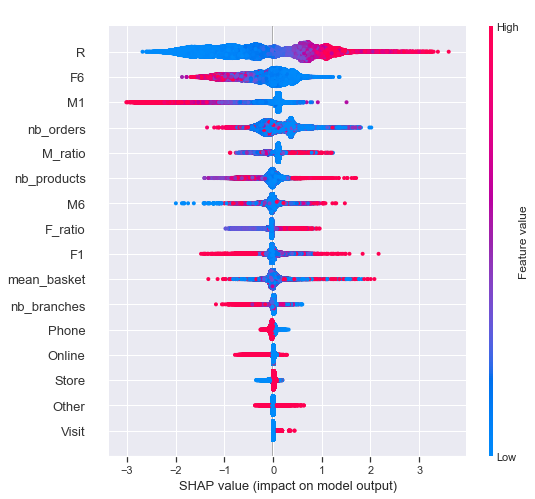

In [86]:
X = df_train.drop(columns = ['churn', 'client_id'], axis = 1)
y = df_train['churn']

X_scaled = StandardScaler().fit_transform(X)

i=0
for col in X.columns :
    X[col] = X_scaled[:,i]
    i += 1

clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', random_state = 1)
clf.fit(X, y)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

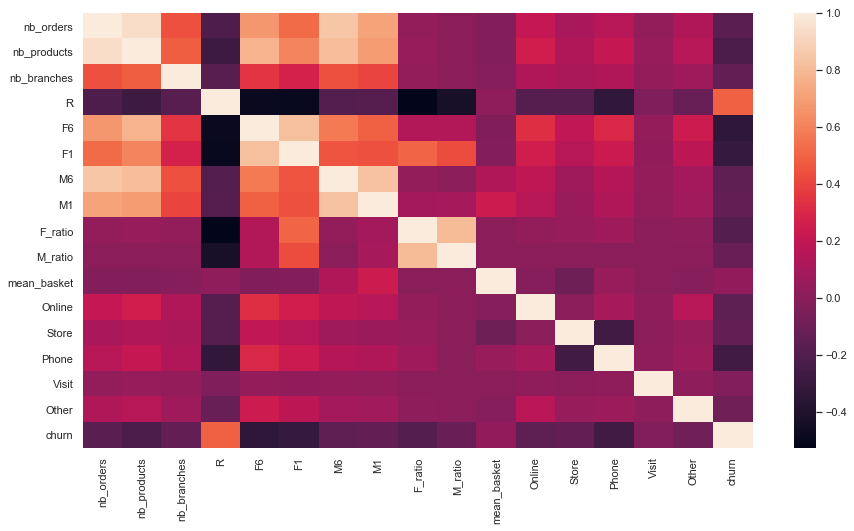

In [85]:
df_corr = df_train.drop(columns = ['client_id'], axis = 1)

df_corr_scaled = StandardScaler().fit_transform(df_corr)

i=0
for col in df_corr.columns :
    df_corr[col] = df_corr_scaled[:,i]
    i += 1

sns.heatmap((df_corr.corr()))

# 4. Basic example of client Segmentation

In [89]:
df_client_date0 = df_test_date.drop(columns = ['churn'], axis = 1)

In [90]:
df_client_date0.head()

,client_id,nb_orders,nb_products,nb_branches,R,F6,F1,M6,M1,F_ratio,M_ratio,mean_basket,Online,Store,Phone,Visit,Other
0,441,19,17,2,80,0.028571,0.000000,3282.887673,0.000000,0.000000,0.000000,172.783562,0,1,1,0,0
1,811,58,29,1,4,0.077778,0.022222,14667.829433,4072.562467,0.285714,1.665916,252.893611,0,0,1,0,0
2,1499,34,28,1,115,0.032680,0.000000,3276.262536,0.000000,0.000000,0.000000,96.360663,0,0,1,0,0
3,1819,143,126,1,5,0.171429,0.040000,36613.240095,8531.077970,0.233333,1.398032,256.036644,0,0,1,0,0
4,1824,7,7,1,157,0.006329,0.000000,150.895947,0.000000,0.000000,0.000000,21.556564,0,0,1,0,0


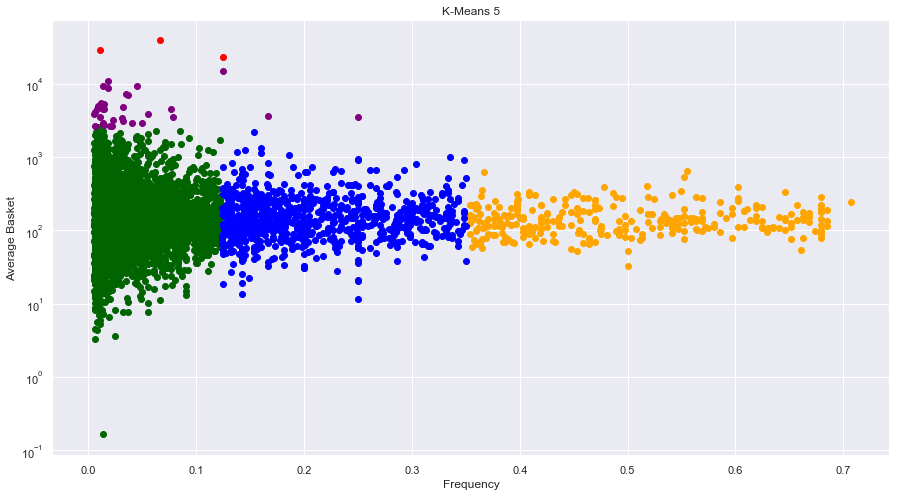

In [111]:
X = df_client_date0[['F6', 'mean_basket']].to_numpy()
X = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=1).fit(X)
df_client_date0['label'] = kmeans.labels_

#filter rows of original data
filtered_label0 = df_client_date0[df_client_date0['label'] == 0]
filtered_label1 = df_client_date0[df_client_date0['label'] == 1]
filtered_label2 = df_client_date0[df_client_date0['label'] == 2]
filtered_label3 = df_client_date0[df_client_date0['label'] == 3]
filtered_label4 = df_client_date0[df_client_date0['label'] == 4]
 
#Plotting the results
plt.scatter(filtered_label0['F6'] , filtered_label0['mean_basket'] , color = 'darkgreen')
plt.scatter(filtered_label1['F6'] , filtered_label1['mean_basket'] , color = 'orange')
plt.scatter(filtered_label2['F6'] , filtered_label2['mean_basket'] , color = 'red')
plt.scatter(filtered_label3['F6'] , filtered_label3['mean_basket'] , color = 'blue')
plt.scatter(filtered_label4['F6'] , filtered_label4['mean_basket'] , color = 'purple')
plt.title('K-Means 5')
plt.xlabel('Frequency')
plt.ylabel('Average Basket')
#plt.xscale('log')
plt.yscale('log')
plt.show()

Ce graphique a pour seule vocation d'illustrer simplement comment il est possible de segmenter les clients selon 2 critères avec un algorithme K-means. En pratique on utilisera plus que 2 critères pour réaliser la segmentation.